# Introduction to Neural Networks

### *By Phi Vu Tran, Booz Allen Hamilton*

## Tutorial Overview

In this tutorial, we use the Python programming language to implement a simple 3-layer feedforward neural network from scratch to solve a multi-classification problem. Neural networks are often mystified as "black box" engines that just seem to work without much intuition. The goal of this exercise is to see how neural networks work under the hood, specifically the main ideas of backpropagation and gradient descent, and learn how to adapt and apply these concepts to new problems.

In order to bound the scope of this tutorial, we assume some basic knowledge of Python coding syntax and supervised machine learning concepts such as logistic regression. Although we strive to incorporate many theoretical and mathematical details to help facilitate the topic, the reader is encouraged to expand upon this tutorial with further reading and research. This tutorial highlights the following important concepts commonly found in a typical machine learning workflow:

* Cross-validation;
* Model training, evaluation, and visualization;
* Hyperparameter selection for experimental design;
* Regularization techniques to mitigate overfitting.

We hope that this tutorial supplements your understanding of deep learning and encourages you to seek the available resources on deep learning frameworks (Theano, Caffe(2), TensorFlow, Keras, PyTorch, MXNet) to facilitate the design and implementation of useful models to advance your own analytical objectives.

**Acknowledgment** - we build upon and expand the tutorials previously made available [here](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch) and [here](http://cs231n.github.io/neural-networks-case-study/). The reader is encouraged to explore more online resources related to neural networks and deep learning in the [Further Reading](#Further-Reading) section.

In [1]:
# Package imports
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from itertools import chain

# Display plots inline
%matplotlib inline

## 1. Generate Dataset

We start by generating a dataset to demonstrate supervised machine learning. Every machine learning study and experiment hinges on some training dataset, and obtaining quality data can be a non-starter. Fortunately, [scikit-learn](http://scikit-learn.org/) has some useful dataset generators and loaders to help us get started. For this tutorial, we select the [`make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) module to create a 2D multi-classification toy dataset.

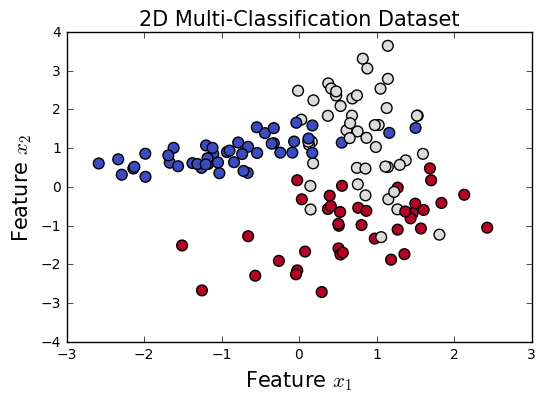

In [2]:
X, y = make_classification(n_samples=200, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3, n_clusters_per_class=1,
                           weights=None, flip_y=0.01, class_sep=0.85, hypercube=True, shift=0.0,
                           scale=1.0, shuffle=True, random_state=0)

# Split the dataset into training and validation segments
X, X_val, y, y_val = train_test_split(X, y, test_size=0.33, random_state=1234)
plt.scatter(X[:, 0], X[:, 1], s=60, c=y, cmap=plt.cm.coolwarm)
plt.xlabel('Feature $x_1$', fontsize=15)
plt.ylabel('Feature $x_2$', fontsize=15)
plt.title("2D Multi-Classification Dataset", fontsize=15)

The dataset we generated has three classes, plotted as blue, red, and gray circles. Programmatically, the three classes are represented as zero-based indices. For our dataset, class 0 is represented by blue circles, class 1 by gray circles, and class 2 by red circles. The chosen colormap goes from cool blue (low value of 0) to warm red (high value of 2). The colors of the circles can be interpreted as real-world categories such as different animal species, and the x- and y-coordinates being some measureable features about each species.

By design, our dataset only has two features, which are easy to visualize. Real-world datasets may have hundreds or thousands of features over many categories, making the task of statistical learning from data very difficult. Thus, we emphasize the importance of the scientific method and sound experimental design to build robust models that produce meaningful and reliable results.

We also split the dataset into training and validation segments, as is customary in a typical machine learning experimentation setup. We train and tune our model on the training segment, and validate the model on the validation set based on some performance metrics. This is known in the literature as [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics).

## 2. Logistic Regression

We baseline our machine learning experiments with logistic regression, and then compare its accuracy performance against a simple feedforward neural network. Logistic regression is a linear probabilistic classifier that works well in many classification tasks because of its proven high performance, ease of implementation, and simplicity in interpretation. The input to the logistic regression model is some training dataset consisting of $x$ observable feature values and corresponding $y$ ground-truth labels. Logistic regression outputs well-calibrated probabilities that can be thresholded to give the predicted class labels. For convenience, we use the logistic regression module from `scikit-learn` to fit our training dataset and visualize its decision boundary. For multi-classification settings where there are more than two classes, we choose `multinomial` over the default `one vs. rest` learning scheme.

In [3]:
# Train the logistic regression linear classifier
clf = LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                           fit_intercept=True, intercept_scaling=1.0, max_iter=200,
                           multi_class='multinomial', n_jobs=1, penalty='l2', random_state=0,
                           refit=True, scoring=None, solver='sag', tol=0.0001, verbose=0)
clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=200,
           multi_class='multinomial', n_jobs=1, penalty='l2',
           random_state=0, refit=True, scoring=None, solver='sag',
           tol=0.0001, verbose=0)

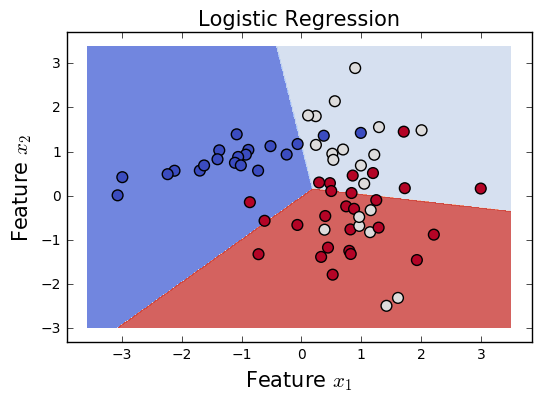

In [4]:
def plot_decision_boundary(pred_func):
    """
    Helper function to plot the decision boundary as a contour plot.
    
    Argument
    --------
    pred_func : function that takes a trained model's parameters (weights)
        and produces an output vector of predicted class labels
    """
    
    # Set min and max values and give it some padding
    x_min, x_max = X_val[:, 0].min() - 0.5, X_val[:, 0].max() + 0.5
    y_min, y_max = X_val[:, 1].min() - 0.5, X_val[:, 1].max() + 0.5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # Plot the function decision boundary. For that, we will assign
    # a color to each point in the mesh [x_min, x_max] by [y_min, y_max].
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X_val[:, 0], X_val[:, 1], s=60, c=y_val, cmap=plt.cm.coolwarm)

# Plot the decision boundary.
# First define the prediction function, which takes a trained model's weights (or parameters)
# to produce an output vector of predicted integer classes
pred_func = lambda x: clf.predict(x)
plot_decision_boundary(pred_func)
plt.xlabel('Feature $x_1$', fontsize=15)
plt.ylabel('Feature $x_2$', fontsize=15)
plt.title("Logistic Regression", fontsize=15)

The plot above shows the decision boundary learned by the logistic classifier. Qualitatively, it looks like the logistic classifier does a good job at separating the data into the three classes using straight lines. But quantitatively, how do we assess the model's classification performance? We will take a closer look at model evaluation in the [Numerical Experiments](#4.-Numerical-Experiments) section.

## 3. Feedforward Neural Network

We now switch our attention to building and characterizing a simple 3-layer feedforward neural network, also known as a multi-layer perceptron, that has one input layer, one hidden layer, and one output layer. Like the name implies, the information flow in feedforward neural networks does not form a cycle, and feedforward network architectures can form arbitrary directed acyclic graphs (DAGs).

The input to the network is a vector of features $x_1$ and $x_2$, along with a *bias unit* $b$ that can be interpreted as the intercept term. The number of units in the input layer is 2, corresponding to the dimensionality of the input data and not counting the bias unit. The number of units in the output layer is 3, corresponding to the number of classes. The output of the network is the probability distribution over class labels. The schematic of the neural network looks something like this:

<img src='./notebook_graphics/nn-diagram.png' style='width: 50%'/>

The dimensionality of the hidden layer is typically set as a user-defined *hyperparameter*. The more units we put into the hidden layer, the more complex functions the network is able to fit. But higher dimensionality comes at a cost for two reasons: (1) more computation is required to learn the network parameters and make predictions; and (2) a larger number of parameters is more prone to overfitting, resulting in a model with poor predictive performance.

How to choose the size of the hidden layer? While there are some general guidelines and recommendations, one way to determine the size of the hidden layer is through cross-validation. In the [Numerical Experiments](#4.-Numerical-Experiments) section, we explore how the size of the hidden layer impacts the accuracy performance of the network on a 
validation dataset.

The units of the hidden layer $a^{(2)}$ transform the input features through an element-wise non-linear *activation function*. Common choices for the activation function are the sigmoid function, $\sigma(z)$, the hyperbolic tangent function, $\mathrm{tanh}(z)$, and the rectified linear unit, $\mathrm{relu}(z)$:

$$
\begin{aligned}
\sigma(z) &= \frac{1}{1 + e^{-z}} \\
\mathrm{tanh}(z) &= \frac{e^z - e^{-z}}{e^z + e^{-z}} \\
\mathrm{relu}(z) &= \mathrm{max}(0,z)
\end{aligned}
$$

We use the ReLU activation function in this tutorial, which performs very well in many scenarios. It also has some nice non-linearity benefits such as:

* Induce sparsity of feature activations;
* Simplify backpropagation because the derivative of ReLU is simply:

$$
\begin{aligned}
\mathrm{relu}^\prime(z) = \frac{d\mathrm{relu}(z)}{dz} =
  \begin{cases}
  1 & z \gt 0 \\
  0 & z \le 0 \\
  \end{cases}
\end{aligned}
$$

* Avoid saturation and vanishing gradient issues associated with sigmoid or tanh;
* More efficient learning and better convergence even without pre-training.

Similarly, the units of the output layer $a^{(3)}$ transform the units of the hidden layer through the element-wise non-linear activation function [softmax](https://en.wikipedia.org/wiki/Softmax_function). The softmax function is used at the output layer as a probabilistic classifier that outputs normalized, well-calibrated class probabilities. The softmax classifier is the generalization of the logistic classifier to multiple classes.

Except for the bias units, all other units in this network architecture are densely, or fully, connected to each other. The downside of each unit being *independently* fully connected to all other units is the large number of parameters needed to learn from the data. Consider an example where the input is an image with the modest size of 28x28 pixels, and the hidden layer has dimensionality of 100, the amount of parameters to learn is on the order of $10^5$. Now suppose the input image has a larger resolution of 96x96 pixels, then the amount of parameters to learn is on the order of $10^6$. The combined forward and backward propagation computations would be about $10 \times 10 = 100$ times slower for the 96x96 image compared to the 28x28 image. A typical image of 256x256 resolution then becomes computationally prohibitive when using a fully connected network.

### 3.1 Forward Propagation

The network makes predictions using *forward propagation*, which is just a bunch of matrix multiplications followed by a bias offset and then element-wise application of the ReLU activation function. For a more compact notation, we drop the superscripts and subscripts and adopt the matrix-vectorial notation. If $x$ is the 2-dimensional input to the network, then we compute the 3-dimensional prediction $\hat{y}$ as follows:

$$
\begin{aligned}
z^{(2)} &= xW^{(1)} + b^{(1)} \\
a^{(2)} &= \mathrm{relu}(z^{(2)}) \\
z^{(3)} &= a^{(2)}W^{(2)} + b^{(2)} \\
a^{(3)} &= \hat{y} = \mathrm{softmax}(z^{(3)})
\end{aligned}
$$

$z^{(i)}$ is the input of layer $i$ and $a^{(i)}$ is the output of layer $i$ after applying the activation function. $W^{(1)}, b^{(1)}, W^{(2)}, b^{(2)}$ are the parameters of the network, which we need to learn from the training data. 

$z^{(2)}$ is the dot (inner) product of the input feature vector $x$ and the weight matrix $W^{(1)}$, offset by the bias vector $b^{(1)}$. Similarly, $z^{(3)}$ is the inner product of the activation vector $a^{(2)}$ and the weight matrix $W^{(2)}$, offset by the bias vector $b^{(2)}$. Recalling the algebraic definition of the dot product, and assuming we use 500 units for the hidden layer, then the dimensionalities of the weight matrices and bias vectors are: $W^{(1)} \in \mathbb{R}^{2\times500}$, $b^{(1)} \in \mathbb{R}^{500}$, $W^{(2)} \in \mathbb{R}^{500\times3}$, $b^{(2)} \in \mathbb{R}^{3}$

The code snippets below demonstrate how the forward propagation is implemented in Python with some helper functions.

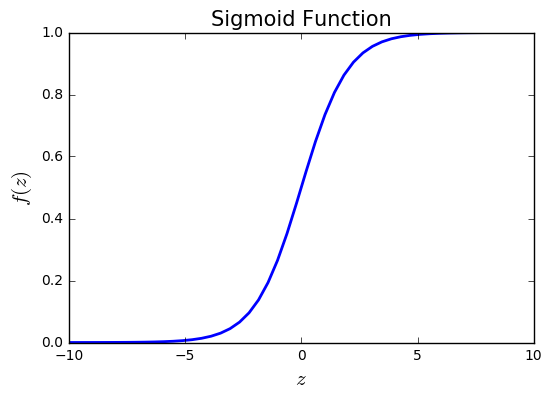

In [5]:
def sigmoid(z):
    """
    Helper function to compute the element-wise sigmoid activation of an array
    """
    
    sigmoid = 1.0 / (1.0 + np.exp(-z))
    dsigmoid = sigmoid * (1.0 - sigmoid)
    
    return sigmoid, dsigmoid

# Plot example sigmoid function
z = np.linspace(-10,10)
fz, _ = sigmoid(z)
plt.plot(z, fz, lw=2)
plt.xlabel('$z$', fontsize=15)
plt.ylabel('$f(z)$', fontsize=15)
plt.title('Sigmoid Function', fontsize=15)

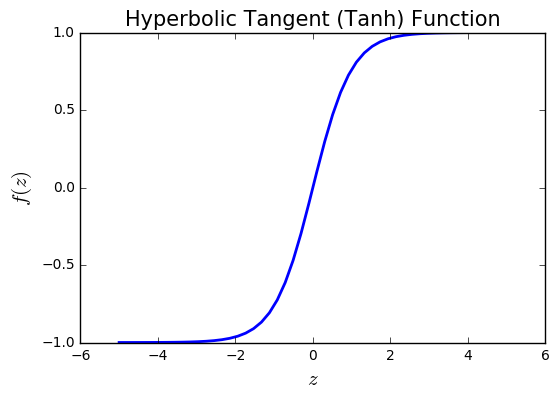

In [6]:
def tanh(x):
    """
    Helper function to compute the element-wise hyperbolic tangent activation of an array
    """
    
    tanh = np.tanh(x)
    dtanh = 1.0 - np.square(tanh)
    
    return tanh, dtanh

# Plot example tanh function
z = np.linspace(-5,5)
fz, _ = tanh(z)
plt.plot(z, fz, lw=2)
plt.xlabel('$z$', fontsize=15)
plt.ylabel('$f(z)$', fontsize=15)
plt.title('Hyperbolic Tangent (Tanh) Function', fontsize=15)

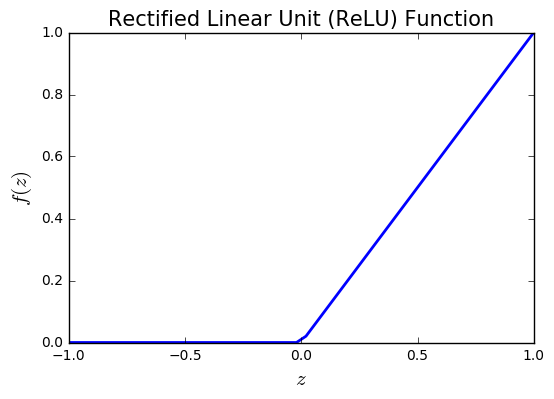

In [7]:
def relu(z):
    """
    Helper function to compute the element-wise ReLU activation
    of an array by simple and efficient thresholding
    """
    
    relu = z * (z > 0)
    drelu = 1.0 * (z > 0)
    
    return relu, drelu

# Plot example ReLU function
z = np.linspace(-1.0, 1.0)
fz, _ = relu(z)
plt.plot(z, fz, lw=2)
plt.xlabel('$z$', fontsize=15)
plt.ylabel('$f(z)$', fontsize=15)
plt.title('Rectified Linear Unit (ReLU) Function', fontsize=15)

In [8]:
def softmax(z):
    """ Helper function to compute the element-wise softmax activation of an array. """
    
    exp = np.exp(z - np.max(z)) # Shift argument to prevent potential numerical instability from large exponentials
    probs = exp / np.sum(exp, axis=1, keepdims=True)
    
    return probs

In [9]:
def reshape(array):
    """ Helper function to reshape input array into weight matrices and bias vectors. """
    
    W1 = np.reshape(array[0:input_dim*hidden_dim], (input_dim, hidden_dim))
    W2 = np.reshape(array[input_dim*hidden_dim:hidden_dim*(input_dim+output_dim)], (hidden_dim, output_dim))
    b1 = array[hidden_dim*(input_dim+output_dim):hidden_dim*(input_dim+output_dim+1)]
    b2 = array[hidden_dim*(input_dim+output_dim+1):]
    
    return W1, W2, b1, b2

In [10]:
def forward(params, x, predict=False):
    """ The forward pass to predict softmax probability distribution over class labels. """
    
    W1, W2, b1, b2 = reshape(params)
    
    # Forward propagation
    z2 = np.dot(x, W1) + b1
    a2, _ = relu(z2)
    z3 = np.dot(a2, W2) + b2
    probs = softmax(z3)

    return np.argmax(probs, axis=1) if predict else probs

### 3.2 Learning and Optimization

When we train the neural network to learn the underlying patterns, signatures, or features of some dataset, we are finding parameters ($W^{(1)}, b^{(1)}, W^{(2)}, b^{(2)}$) that minimize the errors between the network predictions $\hat{y}$ and the ground-truths $y$. But how do we define the error? We call the function that measures error the *loss function*, or sometimes referred to as the *cost function* or the *objective*. Hence, the learning task is defined by the loss function. For the task of multi-classification with the softmax output, the learning function is the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy). If we have $N$ training examples and $C$ classes, then the total loss for the network predictions $\hat{y}$ with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L\left(y,\hat{y}\right) = \underbrace{- \frac{1}{N} \sum_{n \in N} \sum_{c \in C} y_{n,c} \log\hat{y}_{n,c}}_{\text{data loss}} +
\underbrace{\frac{\lambda}{2} \sum_{l} \sum_{j} \sum_{k} \left(W^{(l)}_{j,k}\right)^2}_{\text{regularization penalty loss}}
\end{aligned}
$$

The formula for the total loss $L\left(y, \hat{y}\right)$ comprises two component losses: data loss and regularization penalty loss. The data loss is the function of the difference between the estimated value $\hat{y}$ and true value $y$ for an instance of the training example. For a fixed training set of examples, the data loss becomes the average error over all examples. In essence, the further away $\hat{y}$ and $y$ are, the greater the data loss.

For large and complex networks, the parameters $W$ may be linearly related and their values are not well determined. In other words, the set of parameters $W$ is not necessarily unique, and their values can be strongly influenced by randomness in the training data. The ambiguity of the parameters and their linear dependence is a main reason for overfitting. To help overcome overfitting, we implement a regularization function that explicitly penalizes large values of the parameters to reduce the influence of linear dependence.

The most common regularization penalty is the $L_2$ norm that discourages large weights through an element-wise quadratic penalty over all parameters $W$. In the regularization penalty expression, we sum up all the squared elements of $W$. Notice that the regularization penalty is only a function of the parameters $W$ and not of the data. Therefore, the regularization penalty is often referred to as *weight decay*. The hyperparameter $\lambda$ controls the strength of regularization, with small values of $\lambda$ strongly penalizing large weights. The optimal value of $\lambda$ is dataset-specific, and is usually determined by cross-validation.

Including the regularization penalty in the total loss expression is optional, and can help control overfitting in many cases. The total loss function quantifies our unhappiness with predictions on the training set. Computing the loss function is relatively straightforward in Python, which is shown in the code snippet below.

In [11]:
def compute_loss(params):
    """ Function to compute the average loss over the dataset. """
    
    W1, W2, b1, b2 = reshape(params)
    
    # Forward propagation
    probs = forward(params, X, predict=False)
    
    # Compute the loss
    correct_logprobs = np.log(probs[range(num_examples), y])
    data_loss = -np.sum(correct_logprobs) / num_examples # data loss
    
    reg_loss = weight_decay/2.0 * (np.sum(np.square(W1)) + np.sum(np.square(W2))) # weight_decay is lambda
    
    # Optionally add weight decay regularization term to loss
    loss = data_loss + reg_loss  # total loss including regularization
    
    return loss

### 3.3 Backward Propagation (Backprop)

Recall that the goal is to learn the parameters that minimize the loss function. Hence, learning is cast as an optimization problem. [Gradient descent](http://cs231n.github.io/optimization-1/) is used to minimize the loss function by taking iterative steps in the direction of the negative gradient. Although gradient descent is susceptible to finding local minima of many non-convex loss functions, the algorithm usually works fairly well in practice.

Like the name implies, gradient descent needs the gradient (vector of derivatives) of the loss function with respect to the parameters $(W, b)$: $\frac{\partial{L}}{\partial{W^{(1)}}}$, $\frac{\partial{L}}{\partial{b^{(1)}}}$, $\frac{\partial{L}}{\partial{W^{(2)}}}$, $\frac{\partial{L}}{\partial{b^{(2)}}}$. To compute the gradient, we use the seminal *[backpropagation algorithm](https://www.iro.umontreal.ca/~vincentp/ift3395/lectures/backprop_old.pdf)*, which repeatedly applies the chain rule to differentiate compositions of functions. The mathematical details behind the backpropagation algorithm are beyond the scope of this tutorial; the reader is referred to some excellent expositions of the backpropagtion algorithm found [here](http://colah.github.io/posts/2015-08-Backprop/), [here](http://cs231n.github.io/optimization-2/), and [here](http://deeplearning.stanford.edu/wiki/index.php/Backpropagation_Algorithm).

Applying backpropagation algorithm to the network, we find the following expressions for computing the desired gradient at each layer of the network:

$$
\begin{aligned}
\delta^{(3)} &= \frac{\partial{L}}{\partial{z^{(3)}}} = \hat{y} - y \\
\delta^{(2)} &= \delta^{(3)}(W^{(2)})^T \circ \mathrm{relu}^\prime(z^{(2)}) \\
\frac{\partial{L}}{\partial{W^{(2)}}} &= (a^{(2)})^T \delta^{(3)} \\
\frac{\partial{L}}{\partial{b^{(2)}}} &= \delta^{(3)} \\
\frac{\partial{L}}{\partial{W^{(1)}}} &= x^T \delta^{(2)} \\
\frac{\partial{L}}{\partial{b^{(1)}}} &= \delta^{(2)} \\
\end{aligned}
$$

Now that we have the expressions to compute the gradient of the loss function at each layer of the network, we can train the neural network by taking repeated steps in the direction of the *negative* gradient to *reduce* error in the loss function. The *vanilla* gradient descent procedure for performing a parameter update is as follows:

$$
\begin{aligned}
W^{(l)} &= W^{(l)} - \alpha \left[\left(\frac{1}{N}\frac{\partial{L}}{\partial{W^{(l)}}}\right) + \lambda W^{(l)}\right] \\
b^{(l)} &= b^{(l)} - \alpha \left[\frac{1}{N}\frac{\partial{L}}{\partial{b^{(l)}}}\right],
\end{aligned}
$$

where the supersript $(l)$ refers to the layer index, $\alpha$ is the step size (or learning rate), $N$ is the number of training examples, $\left(\frac{\partial{L}}{\partial{W^{(l)}}}, \frac{\partial{L}}{\partial{b^{(l)}}}\right)$ are the gradient of the loss function with respect to parameters $(W, b)$ at layer $l$, and $\lambda$ is the strength of regularization (or weight decay).

The negative gradient tells us the direction in which the function has the steepest rate of decrease, but it does not tell us how far along this direction we should step. The step size $\alpha$ is an important hyperparameter that can directly impact network performance by influencing how quickly gradient descent converges to a local minimum, or even diverges. The step size must be carefully tuned and set *just right*. If it is set too low, the training progress is steady but slow. And if it is set too high, the training progress can be faster, but more at risk of diverging to the land of `NaN`. 

One best practice to tuning the learning rate $\alpha$ is to initially set it to a relatively high value like `lr = 0.1` to stall the network resulting in large loss, and then successively halve the learning rate until the network begins to show signs of convergence. This procedure may take a few tries to properly work, but it is one way to ensure the network gets the sub-optimal value of $\alpha$ for peak performance.

Putting everything together, the Python code below trains the neural network by way of implementing the concepts of forward propagation, backpropagation, and gradient descent over a number of passes on the training set, or epochs.

In [12]:
def train_nn(hidden_dim, num_passes=200, update_params=True, dropout_ratio=None, print_loss=None):
    """
    This function learns parameters for the neural network via backprop and batch gradient descent.
    
    Arguments
    ----------
    hidden_dim : Number of units in the hidden layer
    num_passes : Number of passes through the training data for gradient descent
    update_params : If True, update parameters via gradient descent
    dropout_ratio : Percentage of units to drop out
    print_loss : If integer, print the loss every integer iterations
    
    Returns
    -------
    params : updated model parameters (weights) stored as an unrolled vector
    grad : gradient computed from backprop stored as an unrolled vector
    """
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(1234)
    W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0/input_dim)
    W2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2.0/hidden_dim)
    b1 = np.ones((1, hidden_dim))
    b2 = np.ones((1, output_dim))
    
    # Gradient descent. For each batch...
    for i in xrange(0, num_passes):

        # Forward propagation
        z2 = np.dot(X, W1) + b1
        a2, da2 = relu(z2)
        if dropout_ratio is not None:
            # Perform inverted dropout.
            # See more info at http://cs231n.github.io/neural-networks-2/#reg
            p = 1.0 - dropout_ratio # Probability of dropping a unit
            u2 = (np.random.rand(*a2.shape) < p) / p
            a2 *= u2
        z3 = np.dot(a2, W2) + b2
        probs = softmax(z3)
        
        # Back propagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1.0
        delta2 = np.dot(delta3, W2.T) * da2
        if dropout_ratio is not None:
            # Perform inverted dropout.
            # See more info at http://cs231n.github.io/neural-networks-2/#reg
            delta2 *= u2
        dW2 = np.dot(a2.T, delta3)
        db2 = delta3
        dW1 = np.dot(X.T, delta2)
        db1 = delta2

        # Scale gradient by the number of examples and add regularization to the weight terms.
        # We do not regularize the bias terms.
        dW2 = (dW2/num_examples) + weight_decay * W2
        dW1 = (dW1/num_examples) + weight_decay * W1
        db2 = np.sum(db2, axis=0, keepdims=True) / num_examples
        db1 = np.sum(db1, axis=0, keepdims=True) / num_examples

        if update_params:
            # Gradient descent parameter update
            W1 += -lr * dW1
            b1 += -lr * db1
            W2 += -lr * dW2
            b2 += -lr * db2
        
        # Unroll model parameters and gradient and store them as a long vector
        params = np.asarray(list(chain(*[W1.flatten(), W2.flatten(), b1.flatten(), b2.flatten()])))
        grad = np.asarray(list(chain(*[dW1.flatten(), dW2.flatten(), db1.flatten(), db2.flatten()])))
        
        # Optionally print the loss after some number of iterations
        if (print_loss is not None) and (i % print_loss == 0):
            print("Loss after iteration %i: %f" %(i, compute_loss(params)))
    
    return params, grad

### 3.4 Gradient Verification

Backpropagation is a notoriously difficult algorithm to debug and get right because there are many suble and nuanced details associated with it. Then, how do we know if the mathematical derivations of the gradient, and their code implementations, are correct? A buggy backpropagation implementation may still produce surprisingly reasonable results, while performing less well than the correct implementation. Gradient descent still steps in the direction of the (wrong) negative gradient to reduce error in the loss function, but does not reach a local minimum if the gradient is incorrect. In this section, we utilize a procedure for numerically checking the computed gradient to ensure correctness in our math and code.

Recall the [centered finite difference formula](https://en.wikipedia.org/wiki/Numerical_differentiation) for computing the numerical derivative of a univariate function is:

$$
\begin{aligned}
\frac{df(x)}{dx} = \lim_{\epsilon \to 0} \frac{f(x+\epsilon) - f(x-\epsilon)}{2\epsilon}
\end{aligned}
$$

The above expression is also called the [symmetric derivative](https://en.wikipedia.org/wiki/Symmetric_derivative), and it can be used to approximate the derivative of any arbitrary differentiable function. For a function of multiple variables, the gradient is the vector of *partial derivatives* with respect to each variable. In the context of our neural network, the function of interest is the loss function $L\left(y, \hat{y}\right)$ and the variables are the parameters $(W, b)$. Choosing $\epsilon$ to be a small constant, say $10^{-4}$, we utilize the symmetric derivative to approximate the numerical gradient of $L\left(y, \hat{y}\right)$ as shown in the Python code snippets below.

In [13]:
def compute_numerical_gradient(func, params):
    """
    For an arbitrary differentiable vector-valued function,
    compute the numerical gradient of the function using the symmetric derivative.
    """
    
    eps = 1e-4
    num_grad = np.zeros(len(params))
    E = np.eye(len(params))
    for i in xrange(len(params)):
        params_plus  = params + eps * E[:, i]
        params_minus = params - eps * E[:, i]
        num_grad[i] = (func(params_plus) - func(params_minus)) / (2.0 * eps)
        
    return num_grad

Next, we verify the correctness of `compute_numerical_gradient()` using a simple quadratic function $f(x,y) = x^2 + 3xy$, which has the closed-form analytical gradient: $\frac{\partial f(x,y)}{\partial x} = 2x + 3y, \frac{\partial f(x,y)}{\partial y} = 3x$.

In [14]:
# Verify the correctness of compute_numerical_gradient() implementation
def quadratic_function(x):
    """
    Simple quadratic function that accepts 2D vector as input:
    f(x,y) = x^2 + 3xy
    """
    
    return x[0]**2 + 3*x[0]*x[1]
    
def quadratic_function_prime(x):
    """
    Compute the analytical gradient of f(x,y) = x^2 + 3xy to give 2D vector of partial derivatives
    df/dx = 2x + 3y
    df/dy = 3x
    """

    grad = np.zeros(x.shape)
    grad[0] = 2*x[0] + 3*x[1]
    grad[1] = 3*x[0]
    
    return grad


x = np.array([4.0, 10.0]) # 2D vector input

grad = quadratic_function_prime(x) # analytical gradient for x
num_grad = compute_numerical_gradient(quadratic_function, x) # numerical gradient for x
abs_error = np.abs(grad - num_grad) # absolute error between grad and num_grad

# inspect analytical grad and num_grad computed from centered finite difference, side by side
fmt = '{:<20}{:<20}{}'
print(fmt.format('Analytical Gradient', 'Numerical Gradient', 'Absolute Error'))
for a,b,c in zip(grad, num_grad, abs_error):
    print(fmt.format(a,b,c))

print("\nMean Absolute Error (expected to be less than 1e-9): {:.12e}".format(np.mean(abs_error)))

Analytical Gradient Numerical Gradient  Absolute Error
38.0                38.0                1.75077730091e-11
12.0                11.9999999998       1.70075509232e-10

Mean Absolute Error (expected to be less than 1e-9): 9.379164112033e-11


Finally, we perform numerical gradient verification on the actual neural network with 3 units in the hidden layer. Feel free to experiment with various constants for the dimensionality of the hidden layer.

In [15]:
# perform numerical gradient checking of the neural network implementation
num_examples = X.shape[0] # number of examples
input_dim = X.shape[1] # input layer dimensionality
hidden_dim = 3 # hidden layer dimensionality
output_dim = len(np.unique(y)) # output layer dimensionality

lr = 0.01 # learning rate for gradient descent
weight_decay = 0.0005 # regularization strength, smaller values provide greater strength

params, grad = train_nn(hidden_dim, update_params=False, dropout_ratio=None, num_passes=1)
num_grad = compute_numerical_gradient(compute_loss, params)
abs_error = np.abs(grad - num_grad)

# inspect grad computed by backprop and num_grad by centered finite difference, side by side
fmt = '{:<20}{:<20}{}'
print(fmt.format('Backprop Gradient', 'Numerical Gradient', 'Absolute Error'))
for a,b,c in zip(grad, num_grad, abs_error):
    print(fmt.format(a,b,c))

print("\nMean Absolute Error (expected to be less than 1e-9): {:.12e}".format(np.mean(abs_error)))

Backprop Gradient   Numerical Gradient  Absolute Error
0.643620991504      0.64362099149       1.40005784743e-11
-1.04613106375      -1.04613106353      2.14070761118e-10
1.01361866775       1.01361866772       3.41715544749e-11
0.423946611485      0.423946611474      1.06156194946e-11
0.590608876495      0.590608876676      1.8060020146e-10
0.91764070975       0.917640709717      3.33868488411e-11
0.543384407061      0.543384407012      4.82198725393e-11
-0.26846359956      -0.268463599493     6.68665123271e-11
-0.274823333616     -0.274823333588     2.75355849233e-11
-0.436364802149     -0.436364802123     2.52480258922e-11
0.32566636537       0.325666365333      3.73662767394e-11
0.110657324866      0.110657324921      5.48060208327e-11
1.42524523615       1.42524523572       4.25658841507e-10
-1.15741819813      -1.15741819809      3.30770966173e-11
-0.268399405413     -0.268399404981     4.31918889543e-10
0.346279161313      0.346279161305      7.94930787862e-12
0.372664359834    

## 4. Numerical Experiments

In this section, we conduct some experiments to assess how the size or dimensionality of the hidden layer of the neural network can directly impact accuracy performance. We also demonstrate how the size of the hidden layer can result in network overfitting, and then utilize dropout regularization to mitigate overfitting.

### Evaluation of Logistic Regression

In [16]:
# Evaluate logistic classifier on validation set
clf_preds = clf.predict(X_val)

print("\nClassification Report for Logistic Regression:\n")
print classification_report(y_val, clf_preds)
print("Validation Accuracy for Logistic Regression: {:.6f}".format(np.mean(y_val==clf_preds)))


Classification Report for Logistic Regression:

             precision    recall  f1-score   support

          0       0.90      0.90      0.90        20
          1       0.54      0.65      0.59        20
          2       0.68      0.58      0.62        26

avg / total       0.71      0.70      0.70        66

Validation Accuracy for Logistic Regression: 0.696970


### Neural Network with 3 Hidden Units

Loss after iteration 0: 5.136004
Loss after iteration 1000: 0.372306
Loss after iteration 2000: 0.335049
Loss after iteration 3000: 0.325840
Loss after iteration 4000: 0.320575
Loss after iteration 5000: 0.316680
Loss after iteration 6000: 0.313423
Loss after iteration 7000: 0.306506
Loss after iteration 8000: 0.297818
Loss after iteration 9000: 0.292972
Loss after iteration 10000: 0.290409
Loss after iteration 11000: 0.288081
Loss after iteration 12000: 0.285855
Loss after iteration 13000: 0.283710
Loss after iteration 14000: 0.280811
Loss after iteration 15000: 0.279027
Loss after iteration 16000: 0.277610
Loss after iteration 17000: 0.276312
Loss after iteration 18000: 0.275078
Loss after iteration 19000: 0.273959

Classification Report for Neural Network:

             precision    recall  f1-score   support

          0       0.90      0.90      0.90        20
          1       0.57      0.60      0.59        20
          2       0.72      0.69      0.71        26

avg / total    

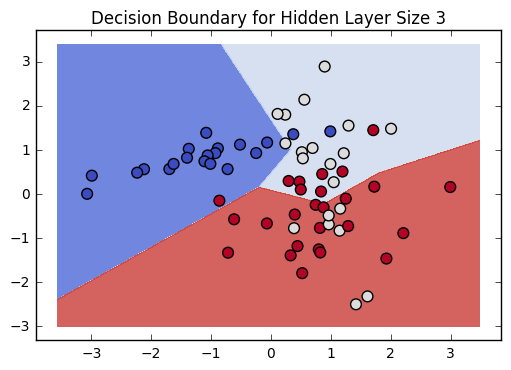

In [17]:
# Fit a model with a 3-dimensional hidden layer
hidden_dim = 3

# Gradient descent parameters
lr = 0.01 # learning rate for gradient descent
weight_decay = 0.0005 # regularization strength, smaller values provide greater strength

# Fit neural network
params, _ = train_nn(hidden_dim, num_passes=20000, dropout_ratio=None, print_loss=1000)

# Evaluate accuracy performance on validation set
nn_preds = forward(params, X_val, predict=True)

print("\nClassification Report for Neural Network:\n")
print classification_report(y_val, nn_preds)
print("Validation Accuracy for Neural Network: {:.6f}".format(np.mean(y_val==nn_preds)))

# Plot the decision boundary
pred_func = lambda x: forward(params, x, predict=True)
plot_decision_boundary(pred_func)
plt.title("Decision Boundary for Hidden Layer Size {:d}".format(hidden_dim))

### Varying the Size of the Hidden Layer

With only three units in the hidden layer, the neural network is able to outperform the logistic classifier on the validation set. How does the size of the hidden layer impact the accuracy performance of the neural network?

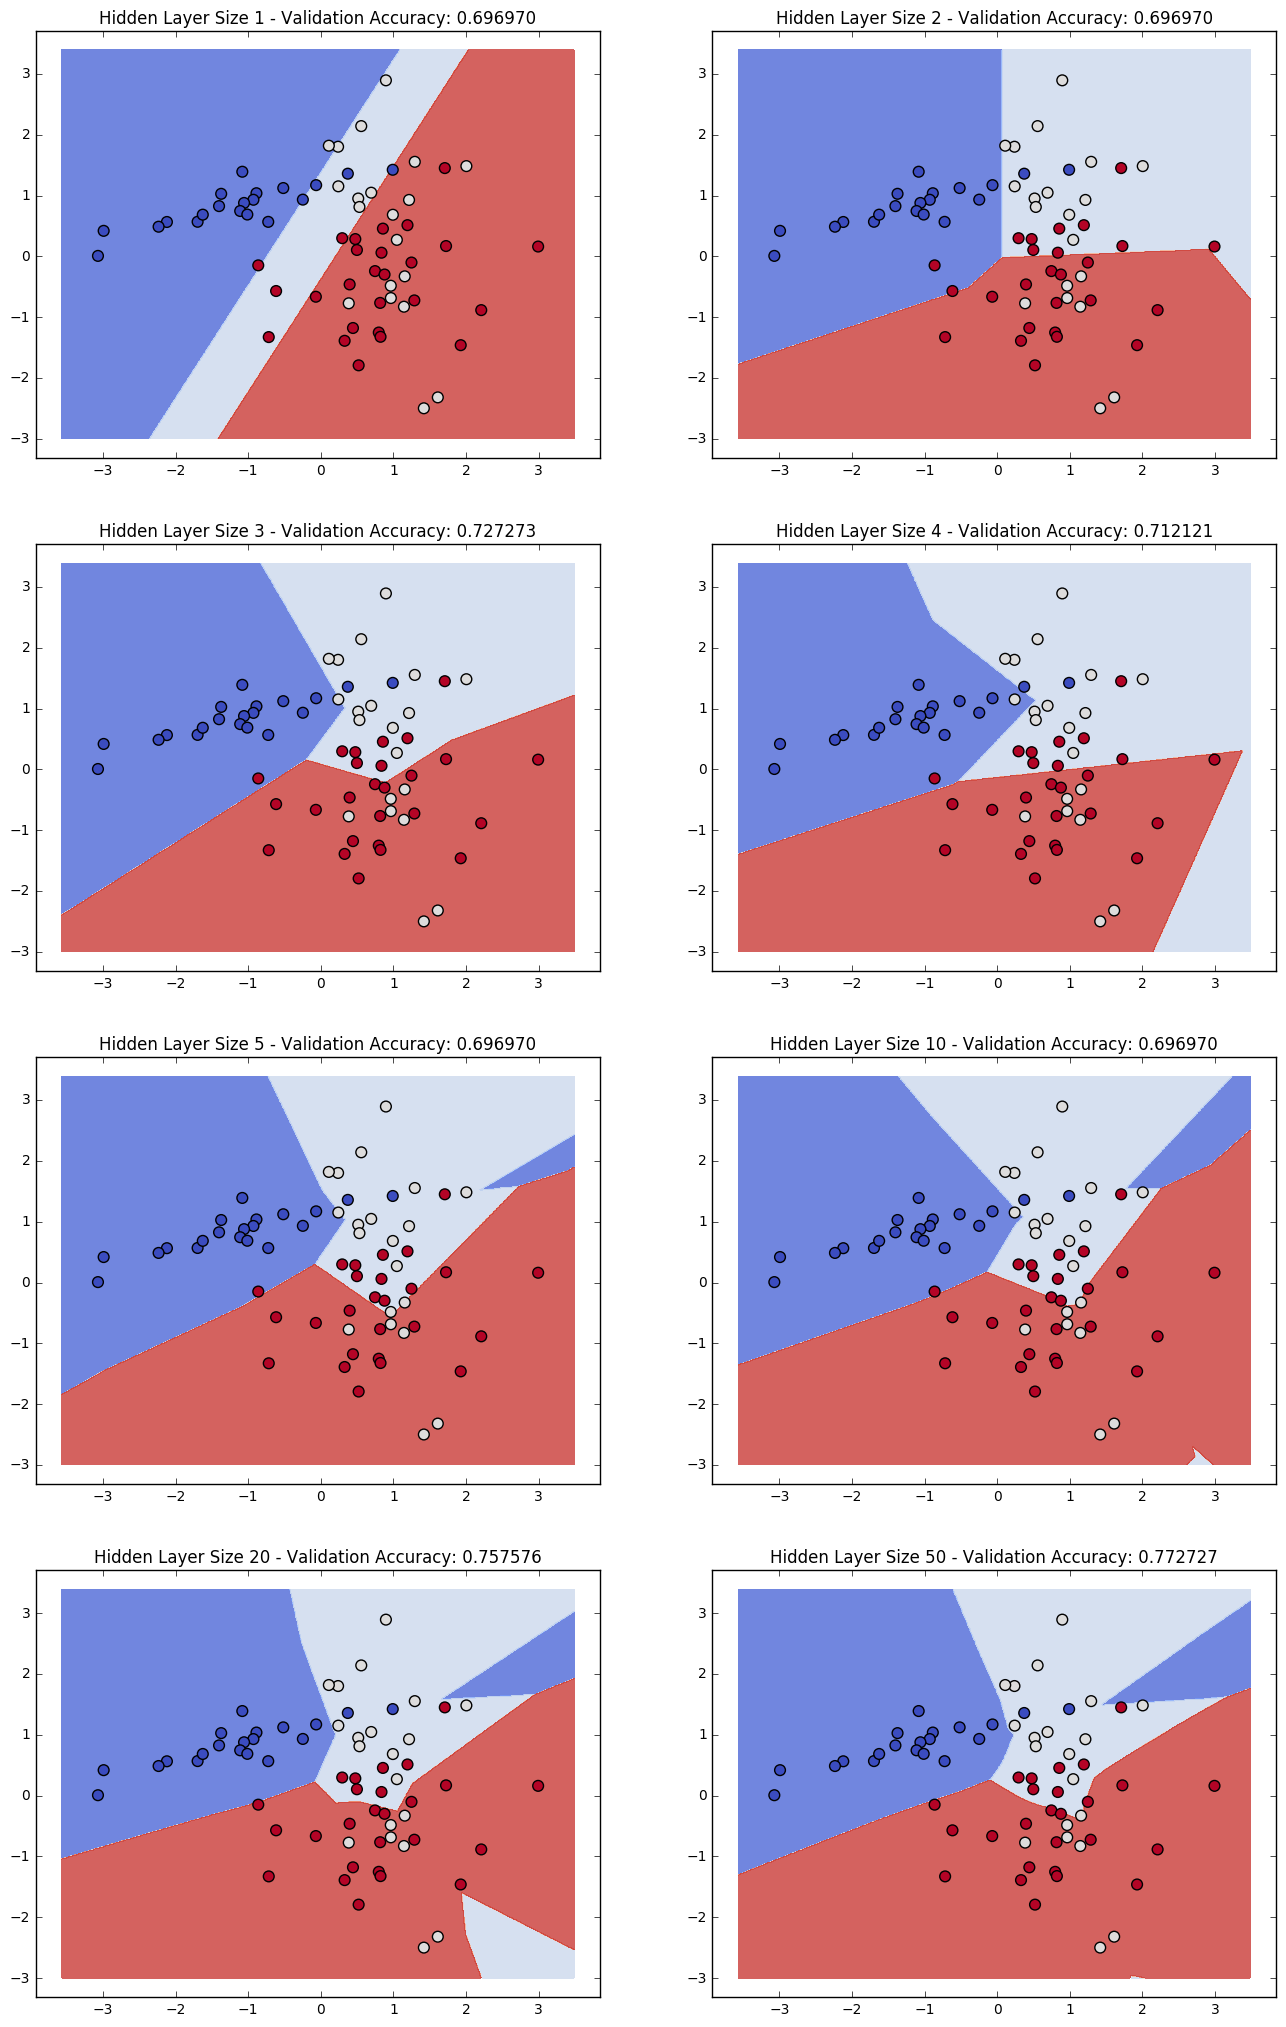

In [18]:
plt.figure(figsize=(16, 32)) # change default figure size
hidden_layer_dimensions = [1, 2, 3, 4, 5, 10, 20, 50]
for i, hidden_dim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    params, grads = train_nn(hidden_dim, num_passes=20000, dropout_ratio=None)
    nn_preds = forward(params, X_val, predict=True)
    plt.title('Hidden Layer Size %d - Validation Accuracy: %.6f' % (hidden_dim, np.mean(y_val==nn_preds)))
    plot_decision_boundary(lambda x: forward(params, x, predict=True))

### Overfitting

Let us try to overfit the neural network with a hidden layer of 200 units. The number of parameters the network needs to learn on a training set with two input features and three output classes is $W^{(1)} \in \mathbb{R}^{2\times200}$, $b^{(1)} \in \mathbb{R}^{200}$, $W^{(2)} \in \mathbb{R}^{200\times3}$, $b^{(2)} \in \mathbb{R}^{3}$, or $2\times200+200+200\times3+3=1,203$. How is accuracy performance affected by a network with 1,203 parameters relative to only 200 training examples?

Loss after iteration 0: 1.824944
Loss after iteration 1000: 0.384236
Loss after iteration 2000: 0.361828
Loss after iteration 3000: 0.348451
Loss after iteration 4000: 0.339086
Loss after iteration 5000: 0.331508
Loss after iteration 6000: 0.324729
Loss after iteration 7000: 0.318846
Loss after iteration 8000: 0.313890
Loss after iteration 9000: 0.309213
Loss after iteration 10000: 0.304782
Loss after iteration 11000: 0.300478
Loss after iteration 12000: 0.296362
Loss after iteration 13000: 0.292614
Loss after iteration 14000: 0.289069
Loss after iteration 15000: 0.285809
Loss after iteration 16000: 0.282678
Loss after iteration 17000: 0.279729
Loss after iteration 18000: 0.276910
Loss after iteration 19000: 0.274183

Classification Report for Hidden Layer Size 200:

             precision    recall  f1-score   support

          0       0.90      0.90      0.90        20
          1       0.57      0.65      0.60        20
          2       0.74      0.65      0.69        26

avg / to

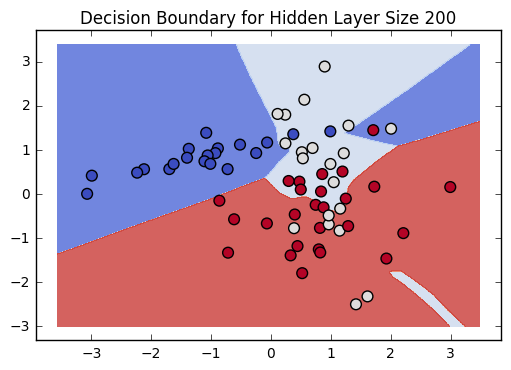

In [19]:
# overfit the neural network by using 200 units in the hidden layer
hidden_dim = 200
params, _ = train_nn(hidden_dim, num_passes=20000, update_params=True, dropout_ratio=None, print_loss=1000)
# Plot the decision boundary
pred_func = lambda x: forward(params, x, predict=True)
plot_decision_boundary(pred_func)
plt.title("Decision Boundary for Hidden Layer Size {:d}".format(hidden_dim))
nn_preds = forward(params, X_val, predict=True)

print("\nClassification Report for Hidden Layer Size {:d}:\n".format(hidden_dim))
print classification_report(y_val, nn_preds)
print("Validation Accuracy for Hidden Layer Size {:d}: {:.6f}".format(hidden_dim, np.mean(y_val==nn_preds)))

### Dropout Regularization

We observe that while a hidden layer of low dimensionality nicely captures the general trend of the training data to produce good accuracy performance on the validation set, higher dimensionalities overfit on the training data and produce worse accuracy performance. In higher dimensionalities, the network is "memorizing" the data as opposed to learning the general patterns, and therefore does not generalize well on the validation set. Notice that we have already implemented weight decay regularization to help mitigate overfitting, but weight decay alone is just not enough in the case of limited training data.

[Dropout](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf) is a simple yet effective network regularization technique that supplements $L_2$ weight decay. While training, dropout is implemented by only keeping some ratio of neurons (along with their connections) active with some probability, or setting them to zero otherwise. With dropout, the neural network is essentially different with each training pass, and thus has the property of preventing units from co-adapting too much. Dropout has been shown to improve the performance of neural networks on a wide variety of supervised learning tasks.

The code section below shows how dropout can overcome the adverse effects of overfitting to improve the accuracy performance of the network with a hidden layer of 200 units.

Loss after iteration 0: 2.057209
Loss after iteration 1000: 0.394945
Loss after iteration 2000: 0.378061
Loss after iteration 3000: 0.369220
Loss after iteration 4000: 0.361779
Loss after iteration 5000: 0.356664
Loss after iteration 6000: 0.352192
Loss after iteration 7000: 0.348074
Loss after iteration 8000: 0.345376
Loss after iteration 9000: 0.342109
Loss after iteration 10000: 0.339218
Loss after iteration 11000: 0.336260
Loss after iteration 12000: 0.334486
Loss after iteration 13000: 0.332938
Loss after iteration 14000: 0.329728
Loss after iteration 15000: 0.328432
Loss after iteration 16000: 0.325810
Loss after iteration 17000: 0.324478
Loss after iteration 18000: 0.322737
Loss after iteration 19000: 0.321375

Classification Report with Dropout:

             precision    recall  f1-score   support

          0       1.00      0.90      0.95        20
          1       0.59      0.65      0.62        20
          2       0.73      0.73      0.73        26

avg / total       0.7

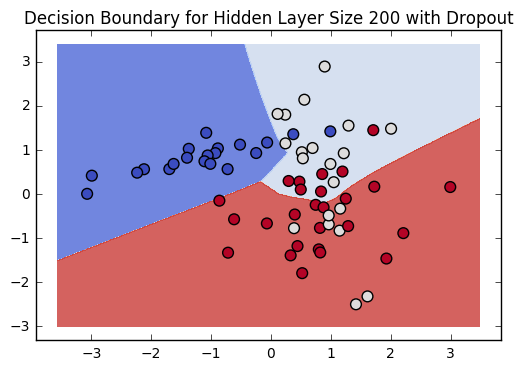

In [20]:
# fit neural network with 200 units in hidden layer, using dropout to mitigate overfitting 
params, _ = train_nn(hidden_dim, num_passes=20000, update_params=True, dropout_ratio=0.5, print_loss=1000)
# Plot the decision boundary
pred_func = lambda x: forward(params, x, predict=True)
plot_decision_boundary(pred_func)
plt.title("Decision Boundary for Hidden Layer Size {:d} with Dropout".format(hidden_dim))
nn_preds = forward(params, X_val, predict=True)

print("\nClassification Report with Dropout:\n")
print classification_report(y_val, nn_preds)
print("Validation Accuracy with Dropout: {:.6f}".format(np.mean(y_val==nn_preds)))

## Further Reading

The reader is encouraged to implement the additional tasks below to become more familiar with the code and further advance their understanding of neural network concepts:

1. Instead of batch gradient descent, use minibatch *stochastic* gradient descent to train the network. Minibatch stochastic gradient descent typically performs better in practice. ([More information](http://cs231n.github.io/optimization-1/#gd))
2. Extend our vanilla gradient descent implementation to include momentum update for better convergence on deep neural networks. ([More information](http://cs231n.github.io/neural-networks-3/#sgd))
3. We used a fixed learning rate for gradient descent. Implement an annealing schedule for the learning rate during gradient descent updates. ([More information](http://cs231n.github.io/neural-networks-3/#anneal))
4. We used the ReLU activation function for our hidden layer. Experiment with other activation functions (Sigmoid, Tanh, Leaky ReLU, Maxout). Note that changing the activation function also means changing the backpropagation derivatives. ([More information](http://cs231n.github.io/neural-networks-1/#actfun))
5. Extend the network to include two hidden layers. Adding another hidden layer means you will need to adjust the code for both forward and backward propagation.